# ВСПОМОГАТЕЛЬНАЯ ЧАСТЬ

## ИМПОРТ

In [1]:
import warnings

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

## НАСТРОЙКИ

In [4]:
from matplotlib.ticker import StrMethodFormatter

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.options.display.float_format = '{:.2f}'.format

## ПУТЬ К ФАЙЛАМ И ПАПКАМ

In [7]:
file_src = r'walmart-sales-dataset-of-45stores.csv'

## ФУНКЦИИ

In [8]:
def fahrenheit_to_celsius(fahrenheit):
    celsius = (fahrenheit - 32) * 5 / 9
    return celsius

In [9]:
def get_conj(x,end_list):
    if len(str(x))>1:
        z = int(str(x)[-2:])
    else:
        z = int(x)
        if z in [2,3,4]:
            return end_list[1]
        elif z == 1:
            return end_list[0]
        else:
            return end_list[2]
    v = z//10
    match v==1:
        case True:
                return end_list[2]
        case False:
                y = z%10
                if y in [2,3,4]:
                    return end_list[1]
                elif y == 1:
                    return end_list[0]
                else:
                    return end_list[2]

## ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ

In [10]:
dict_holi = {'12-02-2010':'super_bowl', '11-02-2011':'super_bowl', '10-02-2012':'super_bowl',
             '10-09-2010':'labor_day', '09-09-2011':'labor_day', '07-09-2012':'labor_day',
            '26-11-2010':'thanksgiving', '25-11-2011':'thanksgiving', '23-11-2012':'thanksgiving',
            '31-12-2010':'xmas', '30-12-2011':'xmas', '28-12-2012':'xmas'}

## ОПИСАНИЕ

В наборе - 8 столбцов:
- Store: цифровой номер магазина (всего 45)
- Date - дата начала недели
- Weekly_Sales - сумма продаж в магазине за неделю
- Holiday_Flag - имеется ли праздник на неделе
- Temperature - средняя температура за отчетную неделю в регионе расположения магазина
- Fuel_Price - цена на топливо в регионе расположения магазина за отчетную неделю
- CPI - индекс потребительских цен
- Unemployment - уровень безработицы в регионе расположения магазина

# РАБОТА С ДАННЫМИ

## ПРЕДОБРАБОТКА

In [11]:
df = pd.read_csv(file_src)

In [12]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11


In [13]:
df.columns=df.columns.map(str.lower)

In [14]:
df['holiday']=df['date'].apply(lambda x: dict_holi[x] if x in dict_holi.keys() else None)

In [15]:
df.loc[df['holiday'].notna()]

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,holiday
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11,super_bowl
31,1,10-09-2010,1507460.69,1,78.69,2.56,211.50,7.79,labor_day
42,1,26-11-2010,1955624.11,1,64.52,2.73,211.75,7.84,thanksgiving
47,1,31-12-2010,1367320.01,1,48.43,2.94,211.40,7.84,xmas
53,1,11-02-2011,1649614.93,1,36.39,3.02,212.94,7.74,super_bowl
...,...,...,...,...,...,...,...,...,...
6375,45,09-09-2011,746129.56,1,71.48,3.74,186.67,8.62,labor_day
6386,45,25-11-2011,1170672.94,1,48.71,3.49,188.35,8.52,thanksgiving
6391,45,30-12-2011,869403.63,1,37.79,3.39,189.06,8.52,xmas
6397,45,10-02-2012,803657.12,1,37.00,3.64,189.71,8.42,super_bowl


In [16]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)

In [17]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   weekly_sales  6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
 8   holiday       450 non-null    object        
 9   year          6435 non-null   int32         
 10  month         6435 non-null   int32         
 11  week          6435 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(2), int64(2), object(1)
memory usage: 534.3+ KB


In [19]:
df['temperature']=df['temperature'].apply(lambda x: fahrenheit_to_celsius(x))

# ГИПОТЕЗЫ И ИССЛЕДОВАНИЯ

## ВЛИЯНИЕ ПРАЗДНИКОВ НА ПРОДАЖИ

### ВЛИЯНИЕ НАЛИЧИЯ/ОТСУТСТВИЯ ПРАЗДНИКОВ

In [20]:
holiday_analysis = df.groupby(['store', 'holiday_flag']).agg({
        'weekly_sales': ['mean', 'std', 'count']
    }).round(2)
    
holiday_analysis['sales_diff'] = holiday_analysis[('weekly_sales', 'mean')] - \
                                    df.groupby('store')['weekly_sales'].mean().values.repeat(2)

In [21]:
print("Влияние праздников по магазинам (первые 10):")
print(holiday_analysis.head(20))

Влияние праздников по магазинам (первые 10):
                   weekly_sales                 sales_diff
                           mean       std count           
store holiday_flag                                        
1     0              1546957.39 148905.44   133   -8307.01
      1              1665747.66 209974.39    10  110483.26
2     0              1914208.81 226714.43   133  -11542.53
      1              2079266.90 330650.41    10  153515.56
3     0               400064.85  42964.45   133   -2639.59
      1               437811.05  72836.28    10   35106.61
4     0              2083555.84 253588.61   133  -11157.12
      1              2243102.62 385468.87    10  148389.66
5     0               314892.28  31647.29   133   -3119.53
      1               359501.61  75657.73    10   41489.80
6     0              1555992.87 202074.12   133   -8735.32
      1              1680907.93 312435.03    10  116179.74
7     0               562964.45 106150.56   133   -7652.86
      1    

In [22]:
# Кластеризация магазинов по реакции на праздники
store_holiday_effect = df.groupby('store',as_index=False).apply(
        lambda x: x[x['holiday_flag'] == 1]['weekly_sales'].mean() / 
                 x[x['holiday_flag'] == 0]['weekly_sales'].mean() - 1
    ).rename(columns={None:'holiday_effect'})

In [23]:
store_holiday_effect

,store,holiday_effect
0,1,0.08
1,2,0.09
2,3,0.09
3,4,0.08
4,5,0.14
5,6,0.08
6,7,0.19
7,8,0.08
8,9,0.09
9,10,0.12


In [24]:
# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
store_holiday_effect['cluster'] = kmeans.fit_predict(store_holiday_effect[['holiday_effect']])

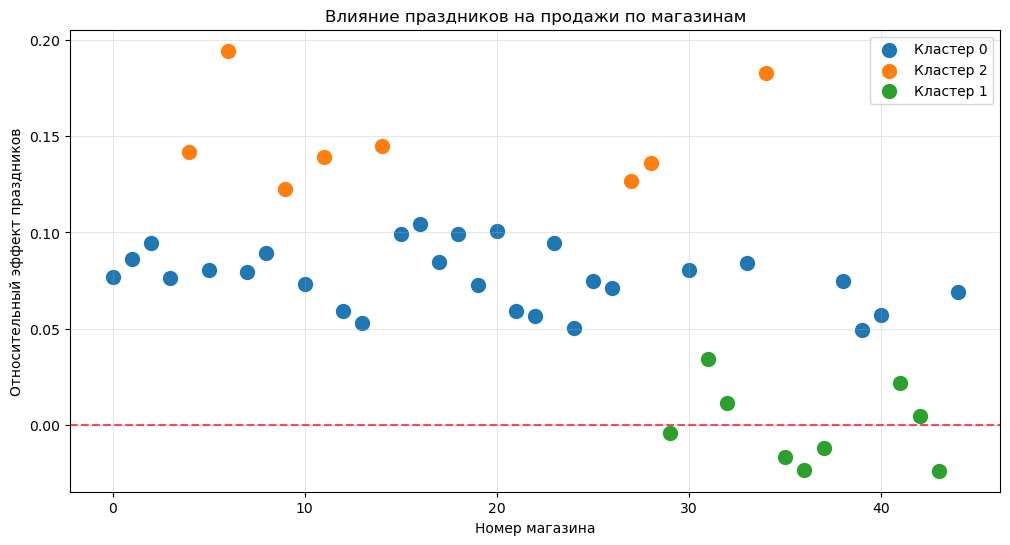

In [25]:
plt.figure(figsize=(12, 6))
for cluster in store_holiday_effect['cluster'].unique():
    cluster_data = store_holiday_effect[store_holiday_effect['cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['holiday_effect'], 
                   label=f'Кластер {cluster}', s=100)
    
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Влияние праздников на продажи по магазинам')
plt.xlabel('Номер магазина')
plt.ylabel('Относительный эффект праздников')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
for cluster in store_holiday_effect['cluster'].unique():
    print(f'Магазины в кластере {cluster} (всего {len(store_holiday_effect.loc[store_holiday_effect['cluster']==cluster])}):')
    print(', '.join(store_holiday_effect.loc[store_holiday_effect['cluster']==cluster,'store'].astype(str).tolist()))

Магазины в кластере 0 (всего 28):
1, 2, 3, 4, 6, 8, 9, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 34, 39, 40, 41, 45
Магазины в кластере 2 (всего 8):
5, 7, 10, 12, 15, 28, 29, 35
Магазины в кластере 1 (всего 9):
30, 32, 33, 36, 37, 38, 42, 43, 44


### ВЛИЯНИЕ КОНКРЕТНЫХ ПРАЗДНИКОВ НА ПРОДАЖИ

In [27]:
print("Уникальные праздники в данных:")
holiday_counts = df['holiday'].value_counts()
print(holiday_counts)

Уникальные праздники в данных:
holiday
super_bowl      135
labor_day       135
thanksgiving     90
xmas             90
Name: count, dtype: int64


In [28]:
# Выделяем только праздничные недели
holiday_data = df[df['holiday_flag'] == 1].copy()

In [29]:
holiday_sales = holiday_data.groupby('holiday').agg({
        'weekly_sales': ['mean', 'std', 'count', 'median', 'min', 'max'],
        'date': ['min', 'max']
    }).round(2)

In [30]:
# Сравнение с обычными днями
normal_sales = df[df['holiday_flag'] == 0]['weekly_sales'].mean()
holiday_sales['sales_vs_normal'] = holiday_sales[('weekly_sales', 'mean')] - normal_sales
holiday_sales['pct_change'] = (holiday_sales[('weekly_sales', 'mean')] / normal_sales - 1) * 100

In [31]:
print("\nДетальный анализ продаж по праздникам:")
print(holiday_sales.sort_values(('pct_change', ''), ascending=False))


Детальный анализ продаж по праздникам:
             weekly_sales                                                  \
                     mean       std count     median       min        max   
holiday                                                                     
thanksgiving   1471273.43 797247.50    90 1327536.25 240044.57 3004702.33   
super_bowl     1079127.99 576945.56   135 1015654.60 276198.74 2462978.28   
labor_day      1042427.29 537894.28   135  976415.56 272834.88 2202742.90   
xmas            960833.11 503227.39    90  889821.96 215359.21 2043245.00   

                   date            sales_vs_normal pct_change  
                    min        max                             
holiday                                                        
thanksgiving 2010-11-26 2011-11-25       430017.05      41.30  
super_bowl   2010-02-12 2012-02-10        37871.61       3.64  
labor_day    2010-09-10 2012-09-07         1170.91       0.11  
xmas         2010-12-31 2011-12-30  

In [32]:
# Статистическая значимость конкретных праздников
for holiday in holiday_data['holiday'].unique():
    if pd.notna(holiday):
        holiday_sales_data = holiday_data[holiday_data['holiday'] == holiday]['weekly_sales']
        normal_sales_data = df[df['holiday_flag'] == 0]['weekly_sales']
            
        t_stat, p_value = stats.ttest_ind(holiday_sales_data, normal_sales_data, equal_var=False)
        print(f"{holiday}: p-value = {p_value:.6f} {'✓' if p_value < 0.05 else '✗'}")


super_bowl: p-value = 0.451676 ✗
labor_day: p-value = 0.980098 ✗
thanksgiving: p-value = 0.000002 ✓
xmas: p-value = 0.136441 ✗


In [33]:
# Сравнение праздников между собой
holiday_groups = [holiday_data[holiday_data['holiday'] == h]['weekly_sales'] 
                     for h in holiday_data['holiday'].unique() if pd.notna(h)]
    
f_stat, p_value = stats.f_oneway(*holiday_groups)
print(f"ANOVA p-value: {p_value:.6f}")
    
if p_value < 0.05:
    print("Есть статистически значимые различия между праздниками")
        
    # Post-hoc тест Тьюки для попарного сравнения
    tukey_data = []
    for idx, row in holiday_data.iterrows():
        if pd.notna(row['holiday']):
            tukey_data.append({
                    'sales': row['weekly_sales'],
                    'holiday': row['holiday']
                })
        
    tukey_df = pd.DataFrame(tukey_data)
    tukey = pairwise_tukeyhsd(tukey_df['sales'], tukey_df['holiday'], alpha=0.05)
    print("\nПопарное сравнение праздников (Tukey HSD):")
    print(tukey)
else:
    print("Нет статистически значимых различий между праздниками")

ANOVA p-value: 0.000000
Есть статистически значимые различия между праздниками

Попарное сравнение праздников (Tukey HSD):
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
   group1       group2      meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------------
   labor_day   super_bowl   36700.6938 0.9591   -152747.41  226148.7976  False
   labor_day thanksgiving  428846.1339    0.0  217036.7147   640655.553   True
   labor_day         xmas  -81594.1824 0.7533 -293403.6015  130215.2368  False
  super_bowl thanksgiving  392145.4401    0.0  180336.0209  603954.8592   True
  super_bowl         xmas -118294.8761 0.4749 -330104.2953    93514.543  False
thanksgiving         xmas -510440.3162    0.0 -742465.9098 -278414.7227   True
------------------------------------------------------------------------------


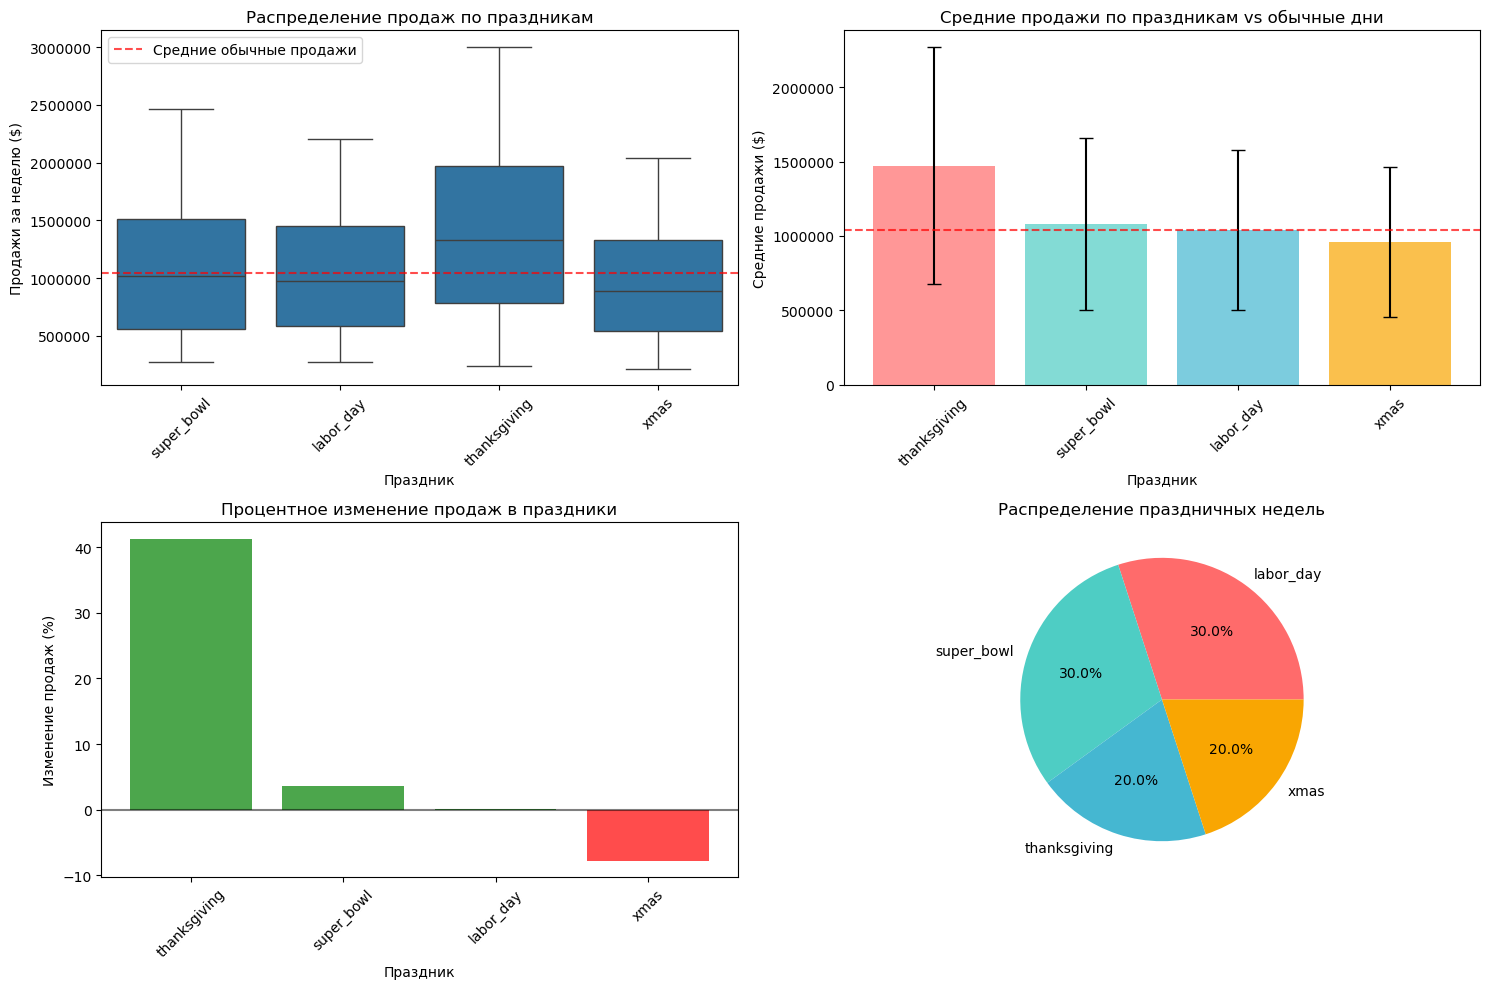

In [34]:
# Визуализация

plt.figure(figsize=(15, 10))
# График 1: Распределение продаж по праздникам
plt.subplot(2, 2, 1).ticklabel_format(style='plain', axis='both')
holiday_data_boxplot = holiday_data[holiday_data['holiday'].notna()]
sns.boxplot(x='holiday', y='weekly_sales', data=holiday_data_boxplot)
plt.axhline(y=normal_sales, color='red', linestyle='--', alpha=0.7, label='Средние обычные продажи')
plt.title('Распределение продаж по праздникам')
plt.xlabel('Праздник')
plt.ylabel('Продажи за неделю ($)')
plt.legend()
plt.xticks(rotation=45)
    
# График 2: Средние продажи по праздникам
plt.subplot(2, 2, 2).ticklabel_format(style='plain', axis='both')
holidays_sorted = holiday_sales.sort_values(('pct_change', ''), ascending=False).index
means = [holiday_sales.loc[h, ('weekly_sales', 'mean')] for h in holidays_sorted]
errors = [holiday_sales.loc[h, ('weekly_sales', 'std')] for h in holidays_sorted]
    
plt.bar(range(len(holidays_sorted)), means, yerr=errors, 
        alpha=0.7, capsize=5, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602'])
plt.axhline(y=normal_sales, color='red', linestyle='--', alpha=0.7)
plt.title('Средние продажи по праздникам vs обычные дни')
plt.xlabel('Праздник')
plt.ylabel('Средние продажи ($)')
plt.xticks(range(len(holidays_sorted)), holidays_sorted, rotation=45)
    
# График 3: Процентное изменение продаж
plt.subplot(2, 2, 3).ticklabel_format(style='plain', axis='both')
pct_changes = holiday_sales['pct_change'].sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in pct_changes]
plt.bar(range(len(pct_changes)), pct_changes, color=colors, alpha=0.7)
plt.title('Процентное изменение продаж в праздники')
plt.xlabel('Праздник')
plt.ylabel('Изменение продаж (%)')
plt.xticks(range(len(pct_changes)), pct_changes.index, rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
# График 4: Количество наблюдений по праздникам
plt.subplot(2, 2, 4).ticklabel_format(style='plain', axis='both')
counts = holiday_sales[('weekly_sales', 'count')]
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', 
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602'])
plt.title('Распределение праздничных недель')
    
plt.tight_layout()
plt.show()

## ВЛИЯНИЕ ТЕМПЕРАТУРЫ НА ПРОДАЖИ

In [35]:
# Расчет корреляции температура-продажи для каждого магазина
store_temp_corr = df.groupby('store').apply(
        lambda x: x['temperature'].corr(x['weekly_sales'])
    ).to_frame('temp_sales_correlation')

In [36]:
# Анализ оптимальной температуры для каждого магазина
store_optimal_temp = df.groupby('store').apply(
        lambda x: x.groupby(pd.cut(x['temperature'], bins=10))['weekly_sales']
                 .mean().idxmax().mid
    ).to_frame('optimal_temperature')
    
temp_sensitivity = pd.merge(store_temp_corr, store_optimal_temp, on='store')


In [37]:
print("Чувствительность к температуре по магазинам:")
print(temp_sensitivity.sort_values('temp_sales_correlation').head(10))


Чувствительность к температуре по магазинам:
       temp_sales_correlation  optimal_temperature
store                                             
10                      -0.43                13.21
12                      -0.38                 8.27
3                       -0.38                12.75
28                      -0.38                11.69
30                      -0.33                 2.84
8                       -0.31                -2.45
37                      -0.30                14.13
2                       -0.30                 8.94
34                      -0.28                 6.76
11                      -0.28                16.11


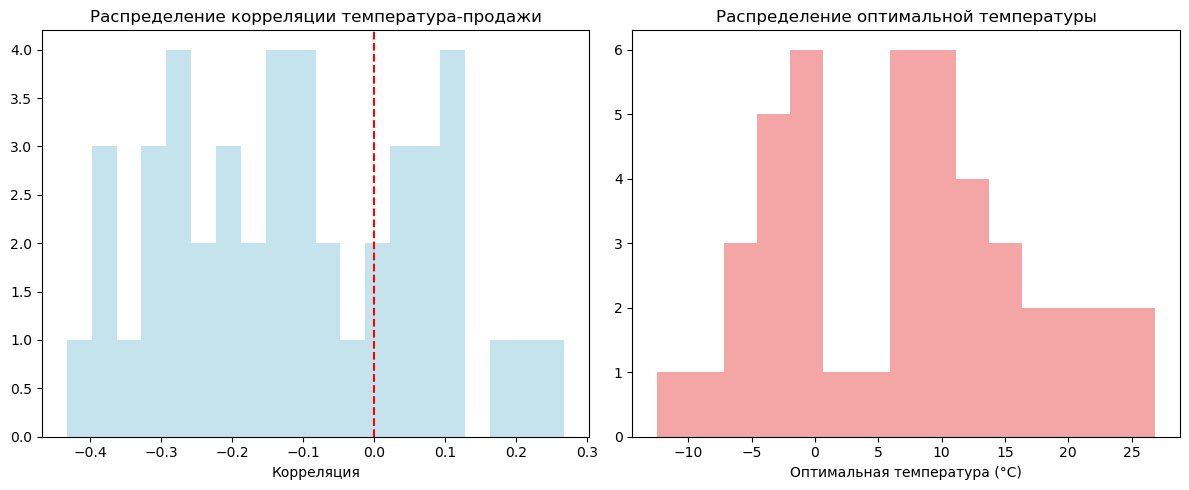

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(temp_sensitivity['temp_sales_correlation'], bins=20, alpha=0.7, color='lightblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Распределение корреляции температура-продажи')
plt.xlabel('Корреляция')
    
plt.subplot(1, 2, 2)
plt.hist(temp_sensitivity['optimal_temperature'], bins=15, alpha=0.7, color='lightcoral')
plt.title('Распределение оптимальной температуры')
plt.xlabel('Оптимальная температура (°C)')
plt.tight_layout()
plt.show()


## ЗАВИСИМОСТЬ ПРОДАЖ ОТ ЭКОНОМИЧЕСКИХ ПОКАЗАТЕЛЕЙ

Здесь анализируется зависимость продаж в конкретном магазине от следующих показателей для региона магазина:  
- CPI
- цены на топливо
- безработица

In [39]:
economic_sensitivity = df.groupby('store').apply(
        lambda x: pd.Series({
            'fuel_correlation': x['fuel_price'].corr(x['weekly_sales']),
            'unemployment_correlation': x['unemployment'].corr(x['weekly_sales']),
            'cpi_correlation': x['cpi'].corr(x['weekly_sales'])
        })
    )
    
print("Чувствительность к экономическим факторам по магазинам:")
print(economic_sensitivity.head(10))

Чувствительность к экономическим факторам по магазинам:
       fuel_correlation  unemployment_correlation  cpi_correlation
store                                                             
1                  0.12                     -0.10             0.23
2                 -0.20                      0.07            -0.06
3                  0.14                     -0.23             0.32
4                  0.21                     -0.34             0.35
5                  0.17                     -0.21             0.31
6                 -0.10                      0.04            -0.01
7                  0.11                     -0.17             0.29
8                  0.03                     -0.05             0.12
9                  0.21                     -0.19             0.29
10                -0.19                      0.13            -0.12


In [40]:
# Кластеризация магазинов по экономической чувствительности
X_economic = economic_sensitivity[['fuel_correlation', 'unemployment_correlation', 'cpi_correlation']]
scaler = StandardScaler()
X_economic_scaled = scaler.fit_transform(X_economic)
    
kmeans = KMeans(n_clusters=3, random_state=42)
economic_sensitivity['economic_cluster'] = kmeans.fit_predict(X_economic_scaled)


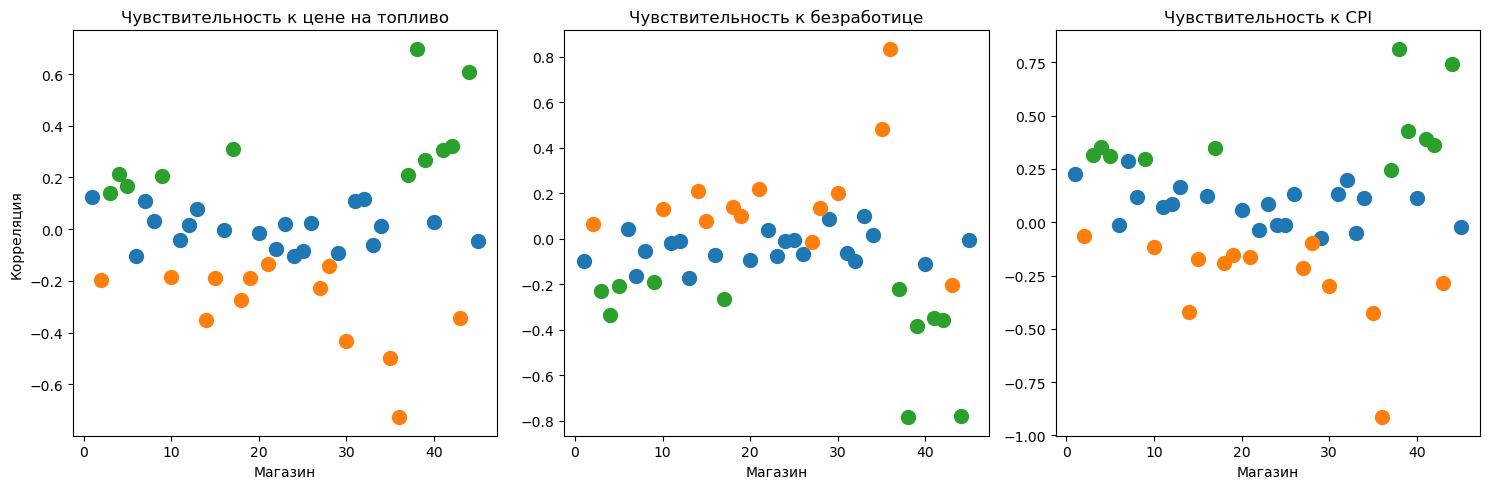

In [41]:
# Визуализация кластеров
fig = plt.figure(figsize=(15, 5))
    
ax1 = fig.add_subplot(131)
for cluster in economic_sensitivity['economic_cluster'].unique():
    cluster_data = economic_sensitivity[economic_sensitivity['economic_cluster'] == cluster]
    ax1.scatter(cluster_data.index, cluster_data['fuel_correlation'], 
                   label=f'Кластер {cluster}', s=100)
ax1.set_title('Чувствительность к цене на топливо')
ax1.set_xlabel('Магазин')
ax1.set_ylabel('Корреляция')
    
ax2 = fig.add_subplot(132)
for cluster in economic_sensitivity['economic_cluster'].unique():
    cluster_data = economic_sensitivity[economic_sensitivity['economic_cluster'] == cluster]
    ax2.scatter(cluster_data.index, cluster_data['unemployment_correlation'], 
                   label=f'Кластер {cluster}', s=100)
ax2.set_title('Чувствительность к безработице')
ax2.set_xlabel('Магазин')
    
ax3 = fig.add_subplot(133)
for cluster in economic_sensitivity['economic_cluster'].unique():
    cluster_data = economic_sensitivity[economic_sensitivity['economic_cluster'] == cluster]
    ax3.scatter(cluster_data.index, cluster_data['cpi_correlation'], 
                   label=f'Кластер {cluster}', s=100)
ax3.set_title('Чувствительность к CPI')
ax3.set_xlabel('Магазин')
    
plt.tight_layout()
plt.show()


## АНАЛИЗ СЕЗОННОСТИ

In [42]:
df_temp = df.copy()

In [43]:
# Создаем временной ряд для каждого магазина
df_temp.set_index('date', inplace=True)

In [44]:
# Анализ сезонности для каждого магазина
store_seasonality = {}
peak_weeks_by_store = {}
    
for store in df_temp['store'].unique():
    store_data = df_temp[df_temp['store'] == store]['weekly_sales']
        
    if len(store_data) > 52: # Минимум год данных для анализа сезонности
        try:
            # Декомпозиция временного ряда
            decomposition = seasonal_decompose(store_data, period=52, model='additive')
                
            store_seasonality[store] = {
                    'trend': decomposition.trend,
                    'seasonal': decomposition.seasonal,
                    'residual': decomposition.resid
            }

                            # Анализ автокорреляции для выявления сезонности
            acf_values = acf(store_data, nlags=52)
            seasonal_lags = np.where(acf_values > 0.3)[0]
                
            # Определение пиковых недель
            seasonal_component = decomposition.seasonal.dropna()
            peak_weeks = seasonal_component.groupby(seasonal_component.index.isocalendar().week).mean()
            top_peak_weeks = peak_weeks.nlargest(5).index.tolist()
                
            peak_weeks_by_store[store] = {
                    'peak_weeks': top_peak_weeks,
                    'seasonal_strength': np.std(seasonal_component) / np.std(store_data),
                    'avg_seasonal_amplitude': np.mean(np.abs(seasonal_component))
                }
                
        except Exception as e:
            print(f"Ошибка при анализе магазина {store}: {e}")
            continue

Кластеризация сезонных паттернов: 4 кластеров


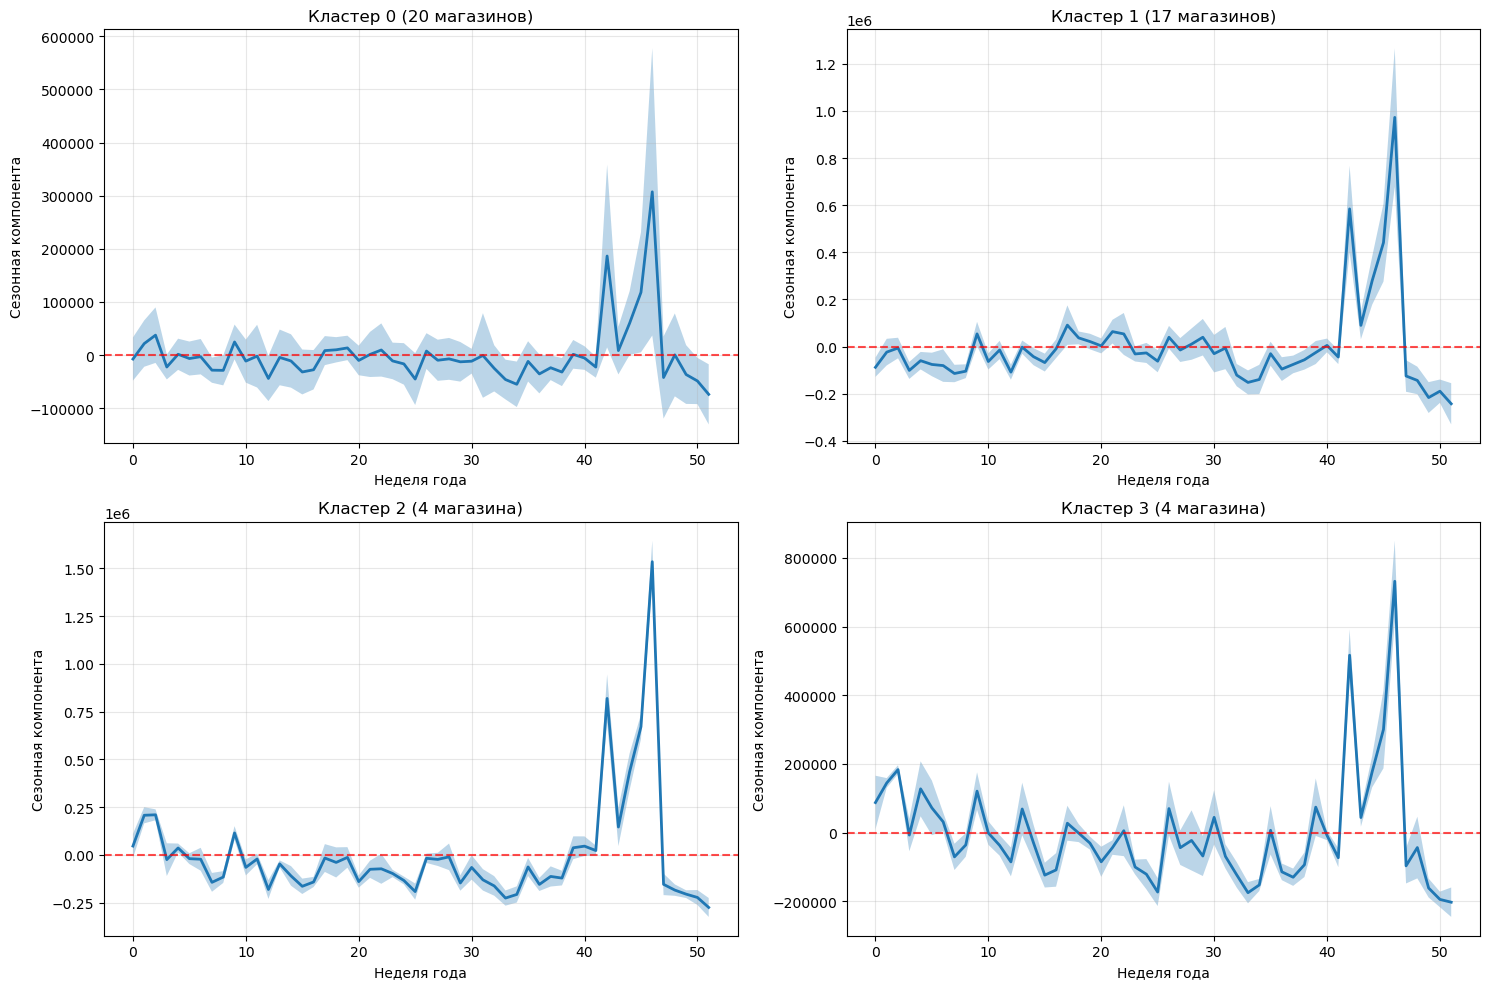

In [45]:
# Анализ общих паттернов сезонности

# Создаем матрицу сезонности для кластеризации
seasonal_matrix = []
store_ids = []
    
for store, data in store_seasonality.items():
    if 'seasonal' in data and data['seasonal'] is not None:
        seasonal_values = data['seasonal'].values
        if len(seasonal_values) >= 52:
            # Берем первые 52 недели сезонной компоненты
            seasonal_matrix.append(seasonal_values[:52])
            store_ids.append(store)
    
if seasonal_matrix:
    seasonal_matrix = np.array(seasonal_matrix)
        
    # Кластеризация магазинов по сезонным паттернам
    scaler = StandardScaler()
    seasonal_scaled = scaler.fit_transform(seasonal_matrix)
        
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(seasonal_scaled)
        
    # Анализ кластеров
    cluster_analysis = {}
    for cluster_id in range(4):
        cluster_stores = [store_ids[i] for i in range(len(store_ids)) if clusters[i] == cluster_id]
        cluster_seasonal = seasonal_matrix[clusters == cluster_id]
            
        cluster_analysis[cluster_id] = {
                'store_count': len(cluster_stores),
                'avg_seasonal_pattern': np.mean(cluster_seasonal, axis=0),
                'stores': cluster_stores
            }
        
    print(f"Кластеризация сезонных паттернов: {len(cluster_analysis)} кластеров")
    # Визуализация сезонных паттернов по кластерам
    plt.figure(figsize=(15, 10))
        
    for cluster_id, data in cluster_analysis.items():
        plt.subplot(2, 2, cluster_id + 1)
        plt.plot(data['avg_seasonal_pattern'], label=f'Кластер {cluster_id}', linewidth=2)
        plt.fill_between(range(52), 
                           data['avg_seasonal_pattern'] - np.std(seasonal_matrix[clusters == cluster_id], axis=0),
                           data['avg_seasonal_pattern'] + np.std(seasonal_matrix[clusters == cluster_id], axis=0),
                           alpha=0.3)
        plt.title(f'Кластер {cluster_id} ({data["store_count"]} магазин{get_conj(data["store_count"],['','а','ов'])})')
        plt.xlabel('Неделя года')
        plt.ylabel('Сезонная компонента')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    plt.show()


## ПРОГНОЗИРОВАНИЕ ПИКОВ СПРОСА В МАГАЗИНАХ

In [46]:
demand_forecasts = {}
anomaly_detection = {}

In [47]:
for store in df_temp['store'].unique():
    if store in store_seasonality:
        # Простое прогнозирование на основе сезонности
        seasonal_pattern = store_seasonality[store]['seasonal']
        trend_component = store_seasonality[store]['trend']
        if seasonal_pattern is not None and trend_component is not None:
            # Прогноз на следующие 4 недели
            last_trend = trend_component.dropna().iloc[-1] if not trend_component.dropna().empty else store_data.mean()
            # Берем сезонность для последних недель года и первых недель следующего
            weeks = list(range(49, 53)) + list(range(1, 5))
            seasonal_forecast = []
            for week in weeks:
                week_seasonality = seasonal_pattern[seasonal_pattern.index.isocalendar().week == week]
                if not week_seasonality.empty:
                    seasonal_forecast.append(week_seasonality.mean())
                else:
                    seasonal_forecast.append(0)
                # Прогноз продаж
            forecast = last_trend + np.array(seasonal_forecast)
                
            demand_forecasts[store] = {
                    'next_4_weeks': forecast,
                    'expected_peaks': weeks[np.argmax(forecast)] if len(forecast) > 0 else None,
                    'peak_magnitude': np.max(forecast) if len(forecast) > 0 else None
                }
        # Обнаружение аномалий с помощью Isolation Forest
        sales_values = store_data.values.reshape(-1, 1)
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        anomalies = iso_forest.fit_predict(sales_values)
            
        anomaly_indices = store_data.index[anomalies == -1]
        anomaly_detection[store] = {
                'anomaly_count': len(anomaly_indices),
                'anomaly_dates': anomaly_indices,
                'anomaly_sales': store_data.loc[anomaly_indices].values if len(anomaly_indices) > 0 else []
            }

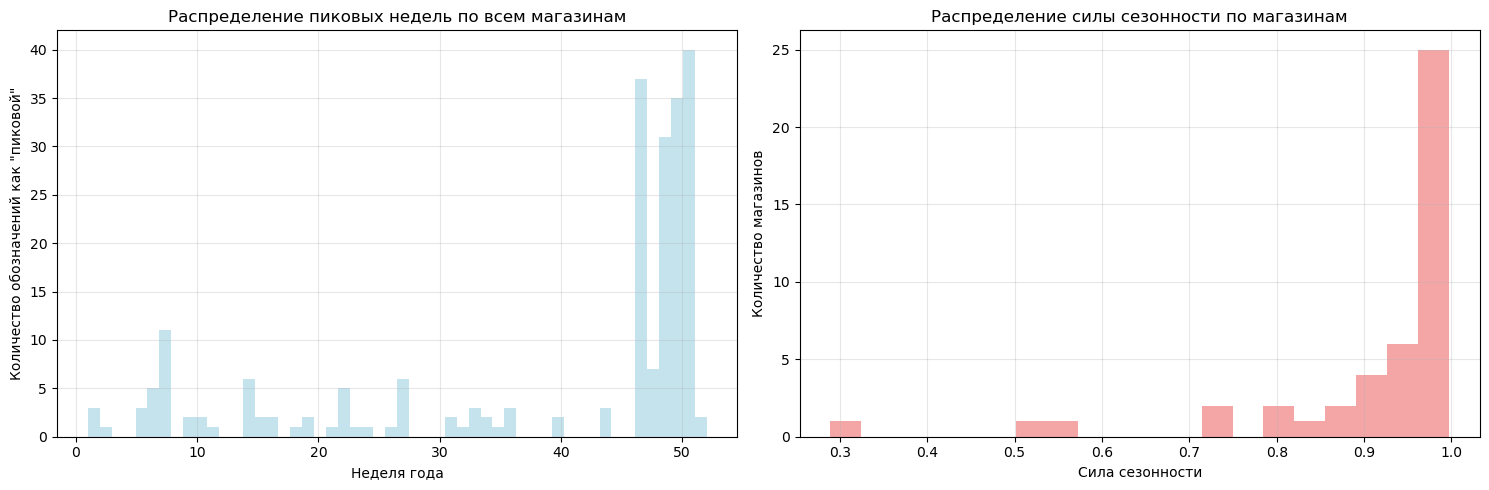

In [48]:
# Визуализация распределения пиковых недель
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 2, 1)
peak_weeks_all = [week for store in peak_weeks_by_store.values() for week in store['peak_weeks']]
plt.hist(peak_weeks_all, bins=52, alpha=0.7, color='lightblue')
plt.title('Распределение пиковых недель по всем магазинам')
plt.xlabel('Неделя года')
plt.ylabel('Количество обозначений как "пиковой"')
plt.grid(True, alpha=0.3)
    
plt.subplot(1, 2, 2)
seasonal_strengths = [store['seasonal_strength'] for store in peak_weeks_by_store.values()]
plt.hist(seasonal_strengths, bins=20, alpha=0.7, color='lightcoral')
plt.title('Распределение силы сезонности по магазинам')
plt.xlabel('Сила сезонности')
plt.ylabel('Количество магазинов')
plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()


## АНАЛИЗ КРОСС-КОРРЕЛЯЦИЙ ВНЕШНИХ ФАКТОРОВ

In [49]:
correlation_results = {}

In [50]:
# Для примера выполняем анализ первых 10 магазинов
for store in df['store'].unique()[:10]: 
    store_data = df[df['store'] == store]
        
    correlations = {
            'temperature': store_data['temperature'].corr(store_data['weekly_sales']),
            'fuel_price': store_data['fuel_price'].corr(store_data['weekly_sales']),
            'unemployment': store_data['unemployment'].corr(store_data['weekly_sales']),
            'cpi': store_data['cpi'].corr(store_data['weekly_sales'])
        }
        
        # Запаздывающие корреляции
    max_lag = 4
    lagged_correlations = {}
        
    for factor in ['temperature', 'fuel_price', 'unemployment', 'cpi']:
        for lag in range(1, max_lag + 1):
            corr = store_data[factor].shift(lag).corr(store_data['weekly_sales'])
            lagged_correlations[f'{factor}_lag_{lag}'] = corr
        
    correlation_results[store] = {**correlations, **lagged_correlations}

In [51]:
# Анализ наиболее значимых корреляций
corr_df = pd.DataFrame(correlation_results).T
print("Корреляции с внешними факторами для первых 10 магазинов:")
print(corr_df.head())

Корреляции с внешними факторами для первых 10 магазинов:
   temperature  fuel_price  unemployment   cpi  temperature_lag_1  \
1        -0.22        0.12         -0.10  0.23              -0.23   
2        -0.30       -0.20          0.07 -0.06              -0.30   
3        -0.38        0.14         -0.23  0.32              -0.36   
4        -0.23        0.21         -0.34  0.35              -0.21   
5        -0.18        0.17         -0.21  0.31              -0.19   

   temperature_lag_2  temperature_lag_3  temperature_lag_4  fuel_price_lag_1  \
1              -0.22              -0.21              -0.16              0.13   
2              -0.29              -0.26              -0.20             -0.18   
3              -0.36              -0.32              -0.25              0.16   
4              -0.20              -0.15              -0.11              0.22   
5              -0.21              -0.21              -0.14              0.18   

   fuel_price_lag_2  fuel_price_lag_3  fuel_pri

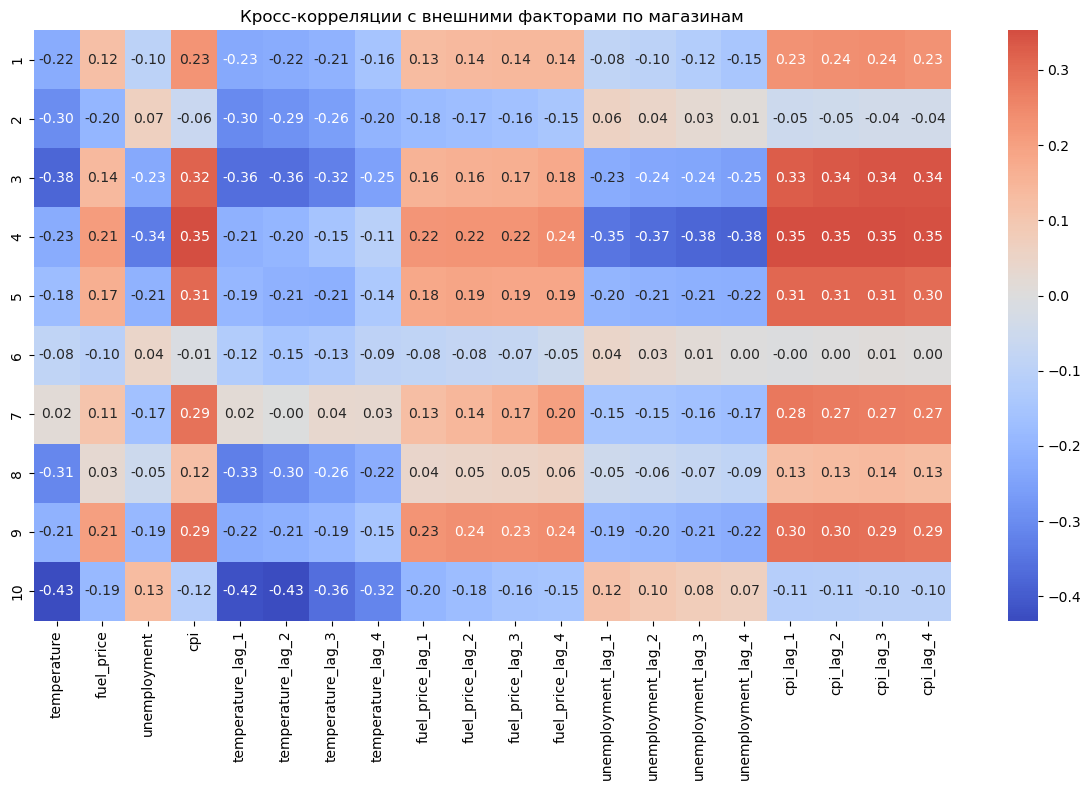

In [52]:
# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Кросс-корреляции с внешними факторами по магазинам')
plt.tight_layout()
plt.show()

# ВЫВОДЫ

**На основании анализа можно сделать следующие выводы:**
1. Праздники оказывают влияние на продажи; при этом наибольшее влияние оказывает День благодарения - на всех графиках, в том числе построенных для прогнозирования продаж по сезонам, видно, что в День благодарения средний объем продаж вырастает кратно. На Рождество объем продаж падает. Вероятнее всего, это связано с тем, что потребители перед Днем благодарения закупаются сразу для двух праздников, и перед Рождеством уже не совершают покупки.
2. В отдельных случаях на продажи также влияет температура, причем можно выделить оптимальные температуры для продаж: от 5 до 15 градусов по Цельсию, и от -5 до 0 градусов по Цельсию. Частично это можно объяснить тем, что температура ниже нуля соответствует температурам в День благодарения. В целом зависимость от температуры обратная, то есть, чем выше температура - тем ниже продажи.
3. Что касается чувствительности к внешним факторам (цены на топливо, уровень безработицы, CPI), выделены 3 группы. Одна группа - это "середнячки", для которых влияние внешних факторов несущественно. Вторая группа и третья группы разделены по влиянию безработицы на объем продаж: во второй группе объем продаж растет с ростом безработицы, в третьей - падает; при этом влияние безработицы на объем продаж обратно влиянию цен на топливо и CPI на объем продаж: если при высокой безработице объем продаж растет, то при высоких ценах на топливо и CPI объем продаж падает; если же при высокой безработице объем продаж падает, то при высоких ценах на топливо и CPI объем продаж будет расти.

**Рекомендации:**
1. Ко Дню благодарения всегда ожидается рост продаж во всех магазинах; необходимо соответствующим образом корректировать запасы товаров. Также есть незначительное увеличение объема продаж на неделе Супер-кубка, его необходимо учитывать. Но рост уровня продаж значительно ниже, чем аналогичный рост в районе Дня благодарения.
2. Для улучшения уровня управления товарными запасами рекомендуется изучить потребительскую корзину в магазинах трех групп, выделенных по влиянию внешних факторов, добавить кластеризацию по товарам с наибольшим спросом в периоды изменения внешних факторов, и отслеживать эти факторы. С учетом изменения цен на топливо можно прогнозировать рост или снижение продаж, а также, при наличии дальнейшей кластеризации по группам товаров, прогнозировать требуемые запасы.
3. Для жаркого времени следует также провести дополнительную кластеризацию по группам товаров, пользующихся наименьшим спросом в это время, и учесть это для планирования запасов.